# 17 Category Flower Dataset  - recruitment task  
Using pretrained VGG16 with summary and further recommendations.  
https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html

In [1]:
import os
import shutil
import tarfile
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer as timer

from PIL import Image
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary

In [2]:
batch_size=8
save_file_name = 'vgg16-transfer-learning.pt'

In [3]:
tar_file = tarfile.open(f"{os.getcwd()}/17flowers.tgz")
tar_file.extractall()

Three possible data splits were attached to dataset in datasplits.mat. Encouraged by commonly used split ratio (50% train, 25% validation, 25% test), I decided to choose first data split from a given file.

In [4]:
data_splits = scipy.io.loadmat(f"{os.getcwd()}/datasplits.mat")
train_nr = data_splits['trn1'][0].tolist()
test_nr = data_splits['tst1'][0].tolist()
val_nr = data_splits['val1'][0].tolist()

Function below modifies folder structure and assigns images into proper class.  
Dataset contains 80 images for each class.  
Modified folder structure:  
&nbsp;-train:  
&nbsp;&nbsp;&nbsp;class_id directory:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;images  
&nbsp;-val:  
&nbsp;&nbsp;&nbsp;class_id directory:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;images  
&nbsp;-test:  
&nbsp;&nbsp;&nbsp;class_id directory:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;images  

In [5]:
root_dir = os.getcwd() + '/jpg'
file_list = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

j=0
for i in range(1, len(file_list)+1):
    source_path = f"{root_dir}/image_{str(i).zfill(4)}.jpg"
    if i in train_nr:
        dest_path = f"{os.getcwd()}/17flowers_dataset/train/{str(j)}"
    elif i in test_nr:
        dest_path = f"{os.getcwd()}/17flowers_dataset/test/{str(j)}"
    else:
        dest_path = f"{os.getcwd()}/17flowers_dataset/val/{str(j)}"
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    shutil.copy(source_path, dest_path)

    if i%80==0:
        j+=1

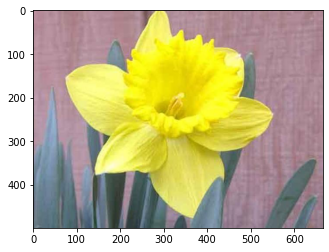

In [6]:
img = mpimg.imread(f"{os.getcwd()}/17flowers_dataset/test/0/image_0004.jpg")
imgplot = plt.imshow(img)
plt.show()

There is small amount of data. Deep learning algorithms are data hungry, so I decided to extend it a bit using data augmentation on a training dataset.

In [7]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),

    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data = {
    'train':
    datasets.ImageFolder(root=f"{os.getcwd()}/17flowers_dataset/train/", transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=f"{os.getcwd()}/17flowers_dataset/val/", transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=f"{os.getcwd()}/17flowers_dataset/test/", transform=image_transforms['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

Dataset is small, so training CNN from scratch should be avoided. I chose to use pretrained VGG16, because of its accuracy on ImageNet dataset. In orded to prevent overfitting classification part contains two dropout layers.

In [9]:
def get_pretrained_model():
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False


    n_inputs = model.classifier[6].in_features

    model.classifier[6] = nn.Sequential(
                        nn.Dropout(0.4),
                        nn.Linear(n_inputs, 128),
                        nn.ReLU(),
                        nn.Dropout(0.4),
                        nn.Linear(128, 17),                   
                        nn.LogSoftmax(dim=1))
    return model

In [10]:
model = get_pretrained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(3, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 224, 224]           1,792
              ReLU-2          [8, 64, 224, 224]               0
            Conv2d-3          [8, 64, 224, 224]          36,928
              ReLU-4          [8, 64, 224, 224]               0
         MaxPool2d-5          [8, 64, 112, 112]               0
            Conv2d-6         [8, 128, 112, 112]          73,856
              ReLU-7         [8, 128, 112, 112]               0
            Conv2d-8         [8, 128, 112, 112]         147,584
              ReLU-9         [8, 128, 112, 112]               0
        MaxPool2d-10           [8, 128, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]         295,168
             ReLU-12           [8, 256, 56, 56]               0
           Conv2d-13           [8, 256, 56, 56]         590,080
             ReLU-14           [8, 256,

In [11]:
model.idx_to_class = ['Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell', 'Crocus', 
                      'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower',
                      'Daisy', 'Colts\' Foot', 'Dandelion', 'Cowslip', 'Buttercup',
                      'Windflower', 'Pansy']

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train() function contains early stopping, which is not used. My goal is to observe patterns in model behaviour by interpretation of historical data.  
What is more, it is advisable to save model and write a function, which loads it from checkpoint. It will allow to re-use model in the future. However, hence it is proof of concept I decided to skip this part.

In [13]:
def train(model, criterion, optimizer, train_loader, val_loader, save_file_name, max_epochs_stop=3, n_epochs=20,
          print_every=2):
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()
    
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()

        for ii, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r'
            )

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in val_loader:
                    output = model(data)

                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(val_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(val_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [14]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=30,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 241.58 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.1564 	Validation Loss: 0.6846
		Training Accuracy: 64.12%	 Validation Accuracy: 82.35%
Epoch: 3	100.00% complete. 247.58 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.7435 	Validation Loss: 0.4825
		Training Accuracy: 78.24%	 Validation Accuracy: 88.24%
Epoch: 5	100.00% complete. 251.13 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.6624 	Validation Loss: 0.4587
		Training Accuracy: 77.79%	 Validation Accuracy: 86.47%
Epoch: 7	100.00% complete. 255.14 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.5550 	Validation Loss: 0.4713
		Training Accuracy: 81.76%	 Validation Accuracy: 84.71%
Epoch: 9	100.00% complete. 242.25 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.5899 	Validation Loss: 0.4402
		Training Accuracy: 81.47%	 Validation Accuracy: 87.65%
Epoch: 11	100.00% complete. 243.13 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.4200 	Va

Text(0.5, 1.0, 'Training and Validation Losses')

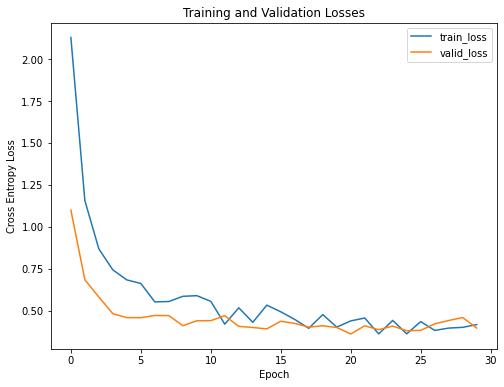

In [15]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Losses')

Learning curves looks promising, even though it is not a classic example of good fit due to plot's generalization gap. Deacrease of both training and validation loss to the stability point can be observed.

Text(0.5, 1.0, 'Training and Validation Accuracy')

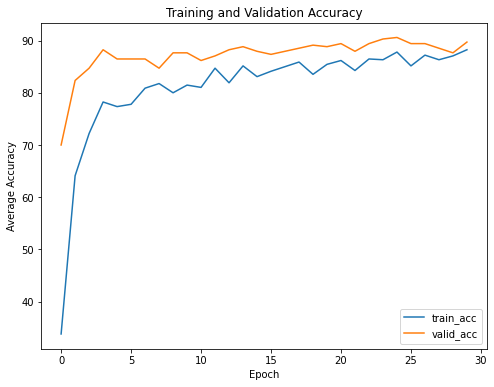

In [16]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

Accuracy of the model looks promising. However, I do not believe it is a final model in real-life scenario. First of all, I would recommend to extend dataset, polish data augmentation and explore different pretrained architectures. Secondly, research of existing state of the art solutions should be conducted, because this proposition could be not sufficient over a larger number of classes.

Model presented above is its second version.  
In the first one both dropout layers was set to 0.3. Although accuracy was around 85% on the validation set, I decided to resign from this solution because of overfitting visible on Cross Entropy Loss plot. Huge generalization gap also suggest that there is a risk of unrepresentative training data, which could be caused by insufficient amount of it.  
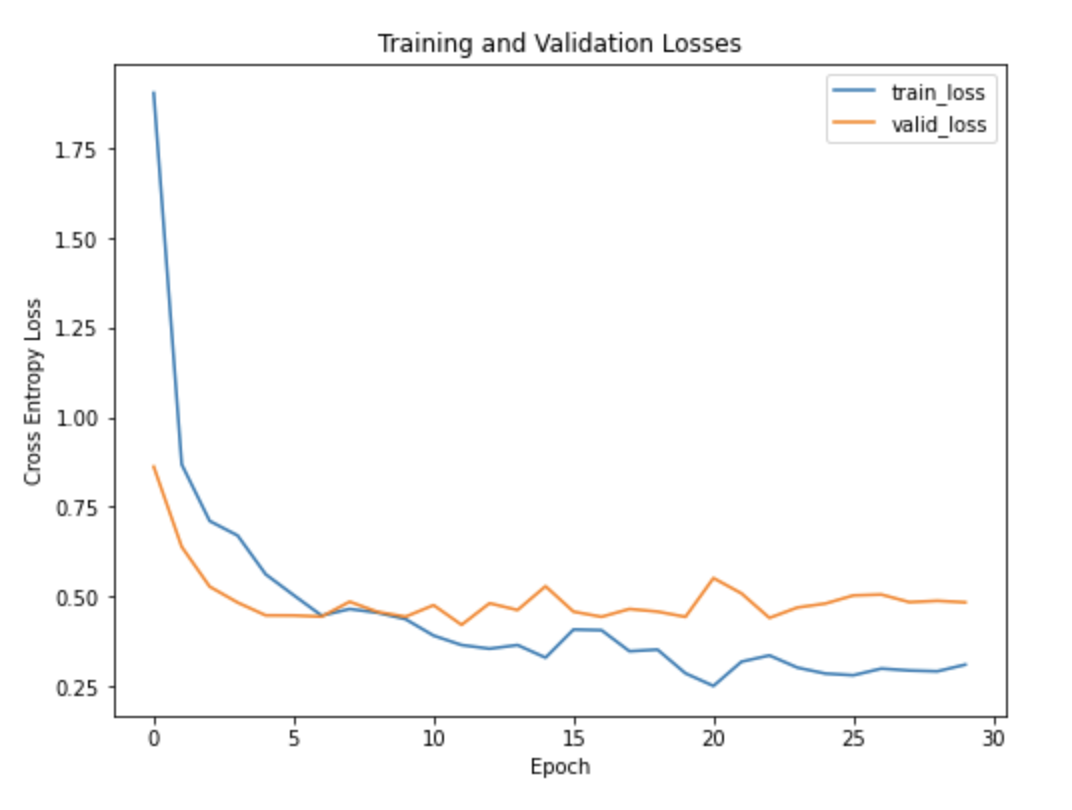

Accuracy plot for model version described above.
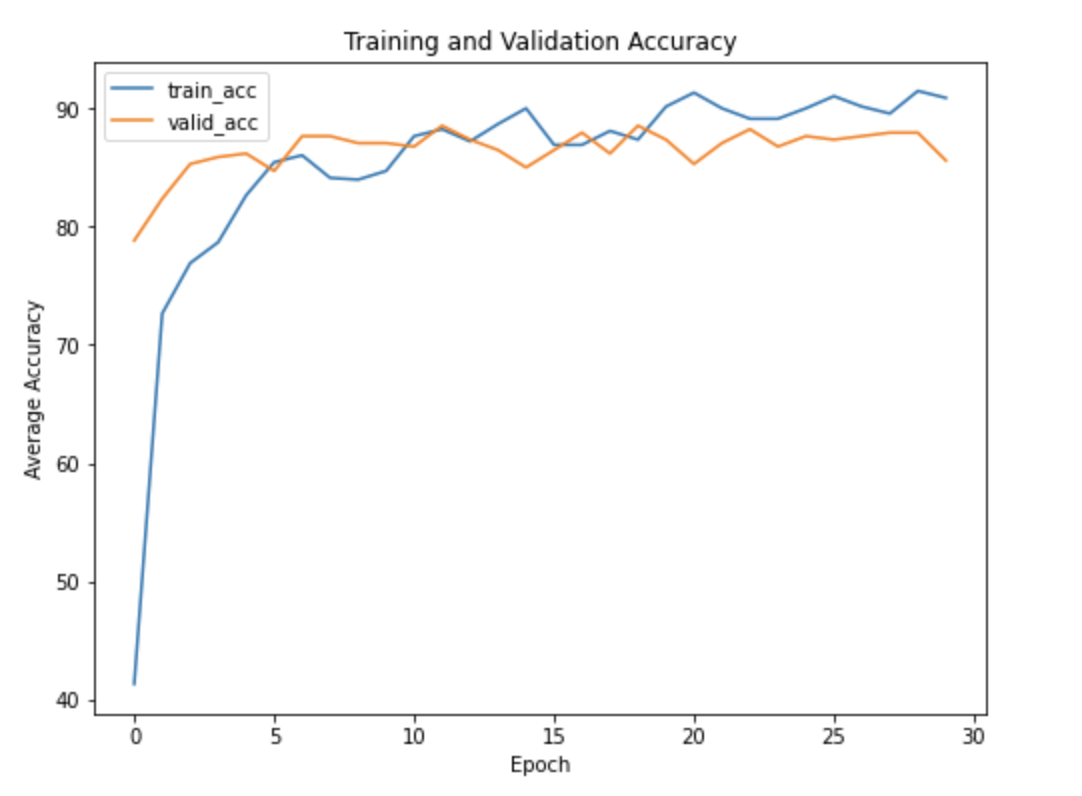

Function process image and returns normalized and properly transformed input to the network.

In [17]:
def process_image(image_path):
    image = Image.open(image_path)
    img = image.resize((256, 256))

    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    img = np.array(img).transpose((2, 0, 1)) / 256

    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

Function transforms image into tensor.

In [18]:
def imshow_tensor(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    plt.axis('off')

    return ax, image

Function which picks up random image from the test dataset.

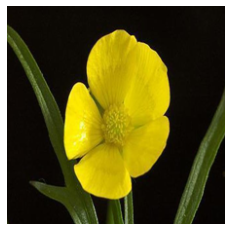

In [19]:
np.random.seed = 100

def random_test_image():
    c = np.random.choice([i for i in range(17)])
    root = f"{os.getcwd()}/17flowers_dataset/test/{c}/"
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

Inference function.

In [20]:
def predict(image_path, model, topk=3):
    real_class = image_path.split('/')[-2]
    img_tensor = process_image(image_path)
    _ = imshow_tensor(img_tensor)
    img_tensor = img_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        out = model(img_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(topk, dim=1)

        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]
        return img_tensor.cpu().squeeze(), top_p, top_classes, model.idx_to_class[int(real_class)]

(array([9.9784470e-01, 1.2602124e-03, 5.6052557e-04], dtype=float32),
 ['Bluebell', 'Crocus', 'Daffodil'],
 "Colts' Foot")

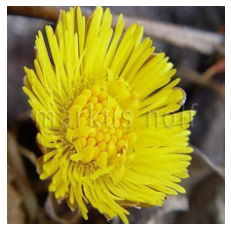

In [21]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

I believe that the best way to present model to the client is by making API in Flask and doing live demo. Additionally, top classes from inference function could be an asset to the final application as a way to propose other most probable classes if out model misclassify an input image. I would increase amount of metrics. Beyond accuracy, recall, precision and F1-measure might be used.  
If I were to share it to my colleague responsible for application building, I would save out model and implement load and inference function in order to re-use my work.  
I spend 4 hours on implementation.